<a href="https://colab.research.google.com/github/nnayar0798/EDA/blob/main/Risk_Assesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install duckdb
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="pastel")

In [2]:
duckdb.sql("""
    CREATE OR REPLACE TABLE txns AS
    SELECT * FROM '/content/risk_transactions_large.csv';
""")
duckdb.sql("SELECT COUNT(*) FROM txns")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│         5000 │
└──────────────┘

In [3]:
##Fraud Rate in overall database
duckdb.sql("""
-- Fraud Metrics Summary
SELECT 'Total Transactions' AS metric,
       COUNT(*) AS value
FROM txns

UNION ALL

SELECT 'Total Fraud Transactions' AS metric,
       SUM(is_fraud) AS value
FROM txns

UNION ALL

SELECT 'Fraud Rate (%)' AS metric,
       ROUND(SUM(is_fraud) * 100.0 / COUNT(*), 2) AS value
FROM txns;

""").to_df()


,metric,value
0,Total Transactions,5000.0
1,Total Fraud Transactions,365.0
2,Fraud Rate (%),7.3


In [4]:
##Top drivers of Fraud Identification
top_df = duckdb.sql("""
WITH mc AS (
    SELECT
        'merchant_category' AS field,
        merchant_category AS category,
        SUM(is_fraud) AS fraud_count,
        COUNT(*) AS total_txns,
        ROUND(SUM(is_fraud)*100.0/COUNT(*),2) AS fraud_rate
    FROM txns
    GROUP BY merchant_category
    ORDER BY fraud_rate DESC
    LIMIT 1
),

ch AS (
    SELECT
        'channel' AS field,
        channel AS category,
        SUM(is_fraud) AS fraud_count,
        COUNT(*) AS total_txns,
        ROUND(SUM(is_fraud)*100.0/COUNT(*),2) AS fraud_rate
    FROM txns
    GROUP BY channel
    ORDER BY fraud_rate DESC
    LIMIT 1
),

rg AS (
    SELECT
        'region' AS field,
        region AS category,
        SUM(is_fraud) AS fraud_count,
        COUNT(*) AS total_txns,
        ROUND(SUM(is_fraud)*100.0/COUNT(*),2) AS fraud_rate
    FROM txns
    GROUP BY region
    ORDER BY fraud_rate DESC
    LIMIT 1
),

pd AS (
    SELECT
        'past_due' AS field,
        CAST(past_due AS VARCHAR) AS category,
        SUM(is_fraud) AS fraud_count,
        COUNT(*) AS total_txns,
        ROUND(SUM(is_fraud)*100.0/COUNT(*),2) AS fraud_rate
    FROM txns
    GROUP BY past_due
    ORDER BY fraud_rate DESC
    LIMIT 1
),

cs AS (
    SELECT
        'credit_score' AS field,
        CASE
            WHEN credit_score < 550 THEN 'Very Low (<550)'
            WHEN credit_score < 650 THEN 'Low (550–649)'
            WHEN credit_score < 750 THEN 'Medium (650–749)'
            ELSE 'High (750+)'
        END AS category,
        SUM(is_fraud) AS fraud_count,
        COUNT(*) AS total_txns,
        ROUND(SUM(is_fraud)*100.0/COUNT(*),2) AS fraud_rate
    FROM txns
    GROUP BY category
    ORDER BY fraud_rate DESC
    LIMIT 1
),

ac_age AS (
    SELECT
        'account_age_days' AS field,
        CASE
            WHEN account_age_days < 30 THEN 'New (<30 days)'
            WHEN account_age_days < 180 THEN 'Medium (30–179 days)'
            ELSE 'Mature (180+)'
        END AS category,
        SUM(is_fraud) AS fraud_count,
        COUNT(*) AS total_txns,
        ROUND(SUM(is_fraud)*100.0/COUNT(*),2) AS fraud_rate
    FROM txns
    GROUP BY category
    ORDER BY fraud_rate DESC
    LIMIT 1
),

ms AS (
    SELECT
        'avg_monthly_spend' AS field,
        CASE
            WHEN avg_monthly_spend < 100 THEN '<100'
            WHEN avg_monthly_spend < 500 THEN '100–499'
            ELSE '500+'
        END AS category,
        SUM(is_fraud) AS fraud_count,
        COUNT(*) AS total_txns,
        ROUND(SUM(is_fraud)*100.0/COUNT(*),2) AS fraud_rate
    FROM txns
    GROUP BY category
    ORDER BY fraud_rate DESC
    LIMIT 1
)

SELECT * FROM mc
UNION ALL SELECT * FROM ch
UNION ALL SELECT * FROM rg
UNION ALL SELECT * FROM pd
UNION ALL SELECT * FROM cs
UNION ALL SELECT * FROM ac_age
UNION ALL SELECT * FROM ms
ORDER BY fraud_rate DESC;

""").to_df()
top_df


,field,category,fraud_count,total_txns,fraud_rate
0,merchant_category,Jewelry,56.0,250,22.40
1,credit_score,Very Low (<550),17.0,76,22.37
2,past_due,1,103.0,715,14.41
3,channel,Online,273.0,2932,9.31
4,account_age_days,Medium (30–179 days),26.0,312,8.33
5,region,West,97.0,1197,8.10
6,avg_monthly_spend,500+,292.0,3948,7.40


In [6]:
##Top drivers of Fraud Identification
cat_df = duckdb.sql("""
WITH mc AS (
    SELECT
        'merchant_category' AS field,
        merchant_category AS category,
        SUM(is_fraud) AS fraud_count,
        COUNT(*) AS total_txns,
        ROUND(SUM(is_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
    FROM txns
    GROUP BY merchant_category
),

ch AS (
    SELECT
        'channel' AS field,
        channel AS category,
        SUM(is_fraud) AS fraud_count,
        COUNT(*) AS total_txns,
        ROUND(SUM(is_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
    FROM txns
    GROUP BY channel
),

rg AS (
    SELECT
        'region' AS field,
        region AS category,
        SUM(is_fraud) AS fraud_count,
        COUNT(*) AS total_txns,
        ROUND(SUM(is_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
    FROM txns
    GROUP BY region
),

pd AS (
    SELECT
        'past_due' AS field,
        CAST(past_due AS VARCHAR) AS category,
        SUM(is_fraud) AS fraud_count,
        COUNT(*) AS total_txns,
        ROUND(SUM(is_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
    FROM txns
    GROUP BY past_due
),

cs AS (
    SELECT
        'credit_score' AS field,
        CASE
            WHEN credit_score < 550 THEN 'Very Low (<550)'
            WHEN credit_score < 650 THEN 'Low (550–649)'
            WHEN credit_score < 750 THEN 'Medium (650–749)'
            ELSE 'High (750+)'
        END AS category,
        SUM(is_fraud) AS fraud_count,
        COUNT(*) AS total_txns,
        ROUND(SUM(is_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
    FROM txns
    GROUP BY category
),

ac_age AS (
    SELECT
        'account_age_days' AS field,
        CASE
            WHEN account_age_days < 30 THEN 'New (<30 days)'
            WHEN account_age_days < 180 THEN 'Medium (30–179 days)'
            ELSE 'Mature (180+)'
        END AS category,
        SUM(is_fraud) AS fraud_count,
        COUNT(*) AS total_txns,
        ROUND(SUM(is_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
    FROM txns
    GROUP BY category
),

ms AS (
    SELECT
        'avg_monthly_spend' AS field,
        CASE
            WHEN avg_monthly_spend < 100 THEN '<100'
            WHEN avg_monthly_spend < 500 THEN '100–499'
            ELSE '500+'
        END AS category,
        SUM(is_fraud) AS fraud_count,
        COUNT(*) AS total_txns,
        ROUND(SUM(is_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
    FROM txns
    GROUP BY category
)

SELECT * FROM mc
UNION ALL SELECT * FROM ch
UNION ALL SELECT * FROM rg
UNION ALL SELECT * FROM pd
UNION ALL SELECT * FROM cs
UNION ALL SELECT * FROM ac_age
UNION ALL SELECT * FROM ms
ORDER BY fraud_rate DESC;
""").to_df()
cat_df


,field,category,fraud_count,total_txns,fraud_rate
0,merchant_category,Jewelry,56.0,250,22.40
1,credit_score,Very Low (<550),17.0,76,22.37
2,merchant_category,Luxury,86.0,513,16.76
3,past_due,1,103.0,715,14.41
4,channel,Online,273.0,2932,9.31
5,credit_score,Low (550–649),129.0,1468,8.79
6,account_age_days,Medium (30–179 days),26.0,312,8.33
7,region,West,97.0,1197,8.10
8,region,Midwest,99.0,1238,8.00
9,avg_monthly_spend,500+,292.0,3948,7.40


In [7]:
#Merchant category fraud rate
merchant_df = duckdb.sql("""
SELECT merchant_category,
       SUM(is_fraud) AS fraud_count,
       COUNT(*) AS total_txns,
       round(SUM(is_fraud)*100.0 / COUNT(*),2) AS 'fraud_rate'
FROM txns
GROUP BY merchant_category
ORDER BY fraud_rate DESC
limit 3
""").to_df()

merchant_df

,merchant_category,fraud_count,total_txns,fraud_rate
0,Jewelry,56.0,250,22.40
1,Luxury,86.0,513,16.76
2,Travel,31.0,474,6.54


/tmp/ipython-input-3453242197.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


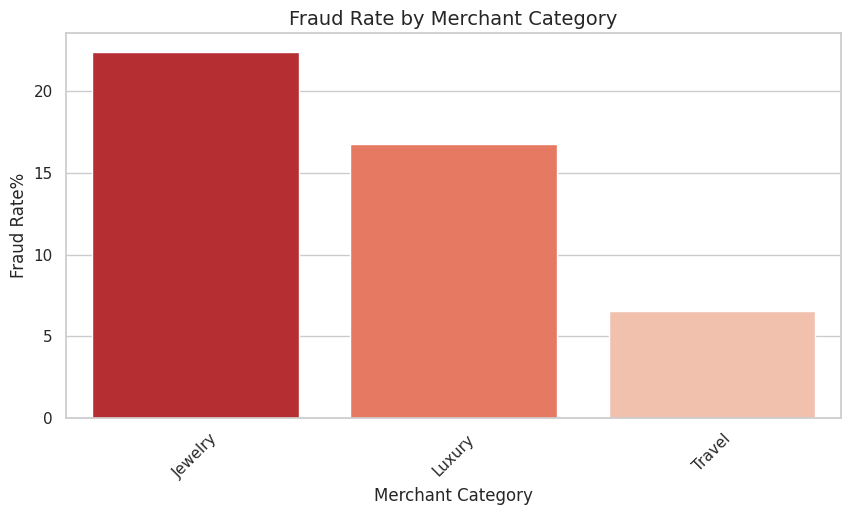

In [8]:
#Visualization of merchant_category fraud rate
plt.figure(figsize=(10,5))
sns.barplot(
    data=merchant_df,
    x="merchant_category",
    y="fraud_rate",
    palette="Reds_r"
)
plt.title("Fraud Rate by Merchant Category", fontsize=14)
plt.xlabel("Merchant Category")
plt.ylabel("Fraud Rate%")
plt.xticks(rotation=45)
plt.show()

In [9]:
#Channel Fraud Rate
channel_df =duckdb.sql("""
SELECT channel,
       SUM(is_fraud) AS fraud_count,
       COUNT(*) AS total_txns,
       round(SUM(is_fraud)*100.0 / COUNT(*),2) AS 'fraud_rate'
FROM txns
GROUP BY channel
ORDER BY fraud_rate DESC
limit 3
""").to_df()
channel_df

,channel,fraud_count,total_txns,fraud_rate
0,Online,273.0,2932,9.31
1,InStore,92.0,2068,4.45


/tmp/ipython-input-809349639.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


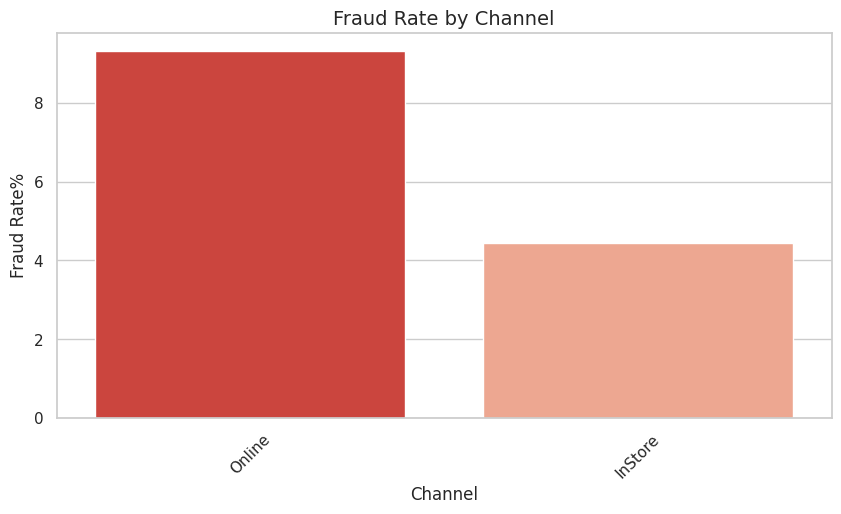

In [10]:
#Visualization of Channel Fraud Rate
plt.figure(figsize=(10,5))
sns.barplot(
    data=channel_df,
    x="channel",
    y="fraud_rate",
    palette="Reds_r"
)
plt.title("Fraud Rate by Channel", fontsize=14)
plt.xlabel("Channel")
plt.ylabel("Fraud Rate%")
plt.xticks(rotation=45)
plt.show()

In [11]:
#Accounts Past due date fraud rate
past_df =duckdb.sql("""
SELECT past_due,
       SUM(is_fraud) AS fraud_count,
       COUNT(*) AS total_txns,
       round(SUM(is_fraud)*100.0 / COUNT(*),2) AS 'fraud_rate'
FROM txns
GROUP BY past_due
ORDER BY fraud_rate DESC
limit 3
""").to_df()
past_df

,past_due,fraud_count,total_txns,fraud_rate
0,1,103.0,715,14.41
1,0,262.0,4285,6.11


/tmp/ipython-input-1423331530.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


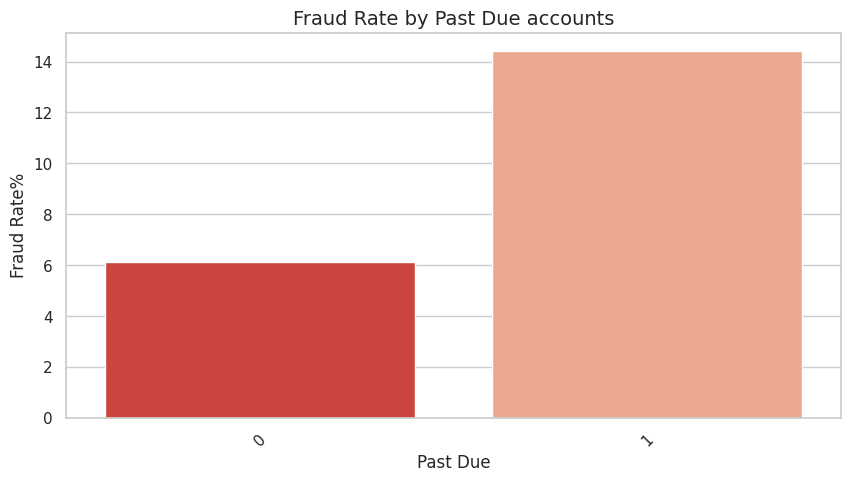

In [12]:
#Visualization of Accounts past due date fraud rate (0 indicates Accounts who have not passed dues and
#1 indicates that have passed due dates)
plt.figure(figsize=(10,5))
sns.barplot(
    data=past_df,
    x="past_due",
    y="fraud_rate",
    palette="Reds_r"
)
plt.title("Fraud Rate by Past Due accounts", fontsize=14)
plt.xlabel("Past Due")
plt.ylabel("Fraud Rate%")
plt.xticks(rotation=45)
plt.show()

In [13]:
# Credit score fraud rate
credit_df = duckdb.sql("""
SELECT
    'credit_score' AS field,
    CASE
        WHEN credit_score < 550 THEN 'Very Low (<550)'
        WHEN credit_score < 650 THEN 'Low (550–649)'
        WHEN credit_score < 750 THEN 'Medium (650–749)'
        ELSE 'High (750+)'
    END AS category,
    SUM(is_fraud) AS fraud_count,
    COUNT(*) AS total_txns,
    ROUND(SUM(is_fraud)*100.0/COUNT(*), 2) AS fraud_rate
FROM txns
GROUP BY
    CASE
        WHEN credit_score < 550 THEN 'Very Low (<550)'
        WHEN credit_score < 650 THEN 'Low (550–649)'
        WHEN credit_score < 750 THEN 'Medium (650–749)'
        ELSE 'High (750+)'
    END
ORDER BY fraud_rate DESC;
""").to_df()

credit_df


,field,category,fraud_count,total_txns,fraud_rate
0,credit_score,Very Low (<550),17.0,76,22.37
1,credit_score,Low (550–649),129.0,1468,8.79
2,credit_score,High (750+),40.0,625,6.40
3,credit_score,Medium (650–749),179.0,2831,6.32


/tmp/ipython-input-3172707719.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


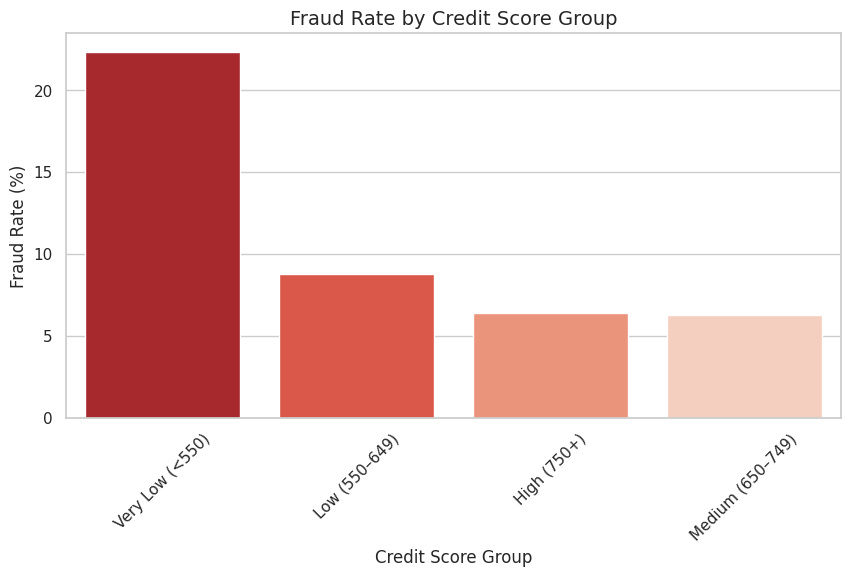

In [14]:
#Visualization of Credit Score Group fraud rate
plt.figure(figsize=(10,5))
sns.barplot(
    data=credit_df,
    x="category",
    y="fraud_rate",
    palette="Reds_r"
)
plt.title("Fraud Rate by Credit Score Group", fontsize=14)
plt.xlabel("Credit Score Group")
plt.ylabel("Fraud Rate (%)")
plt.xticks(rotation=45)
plt.show()


In [16]:
#Region based fraud rate
region_df = duckdb.sql("""
SELECT region,
       SUM(is_fraud) AS fraud_count,
       COUNT(*) AS total_txns,
       round(SUM(is_fraud)*100.0 / COUNT(*),2) AS 'fraud_rate'
FROM txns
GROUP BY region
ORDER BY fraud_rate DESC
limit 3
""").to_df()
region_df

,region,fraud_count,total_txns,fraud_rate
0,West,97.0,1197,8.10
1,Midwest,99.0,1238,8.00
2,South,88.0,1287,6.84


In [17]:
#Rule-based risk flagging system based on exploratory data analysis
risk_df = duckdb.sql("""
SELECT
    t.*,
    CASE

        WHEN
            (
                -- 1. High-risk merchant + online
                merchant_category IN ('Jewelry', 'Luxury')
                AND channel = 'Online'
            )
            OR
            (
                -- 2. Very low credit score
                credit_score < 550
            )
            OR
            (
                -- 3. Past-due and high amount
                past_due = 1
                AND amount > 400
            )
            OR
            (
                -- 4. Online and very high amount
                channel = 'Online'
                AND amount > 800
            )
        THEN 'High'

        -- MEDIUM RISK (only if not High; CASE ensures this)
        WHEN
            (
                -- 1. Travel/Electronics online
                merchant_category IN ('Travel', 'Electronics')
                AND channel = 'Online'
            )
            OR
            (
                -- 2. Past-due (any amount)
                past_due = 1
            )
            OR
            (
                -- 3. Any online transaction
                channel = 'Online'
            )
        THEN 'Medium'

        -- LOW RISK
        ELSE 'Low'
    END AS risk_bucket
FROM txns t;
""").to_df()
risk_df

,transaction_id,customer_id,transaction_date,amount,merchant_category,channel,is_fraud,credit_score,account_age_days,avg_monthly_spend,past_due,region,risk_bucket
0,T00001,C202,2025-01-08,362.29,Grocery,InStore,0,711,1732,734,0,Northeast,Low
1,T00002,C535,2025-01-23,158.66,FastFood,Online,0,717,1463,1270,1,Northeast,Medium
2,T00003,C448,2025-01-14,210.74,Grocery,Online,0,649,354,1463,0,West,Medium
3,T00004,C370,2025-02-25,2.21,Travel,Online,1,730,1351,663,0,West,Medium
4,T00005,C206,2025-02-24,353.02,Grocery,Online,0,734,2258,279,0,Northeast,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,T04996,C210,2025-02-18,468.78,FastFood,Online,0,763,1597,1691,0,South,Medium
4996,T04997,C514,2025-02-07,64.60,Grocery,Online,0,794,974,1799,0,Northeast,Medium
4997,T04998,C389,2025-01-23,91.04,Grocery,InStore,0,680,2407,1787,0,Midwest,Low
4998,T04999,C394,2025-01-22,215.60,Luxury,InStore,0,634,1279,1213,0,South,Low


In [18]:
#Customers who exhibit unusually large changes in spending
#Comparing spend in the month of Jan VS Feb
cust_z_df = duckdb.sql("""
WITH monthly AS (
    SELECT
        customer_id,
        DATE_TRUNC('month', CAST(transaction_date AS DATE)) AS month,
        SUM(amount) AS monthly_spend
    FROM txns
    GROUP BY customer_id, month
),

pivoted AS (
    SELECT
        customer_id,
        round(SUM(CASE WHEN month = DATE '2025-01-01' THEN monthly_spend ELSE 0 END),2) AS jan_spend,
        round(SUM(CASE WHEN month = DATE '2025-02-01' THEN monthly_spend ELSE 0 END), 2) AS feb_spend
    FROM monthly
    GROUP BY customer_id
),

diffs AS (
    SELECT
        customer_id,
        jan_spend,
        feb_spend,
        round((feb_spend - jan_spend),2) AS delta_spend
    FROM pivoted
),

stats AS (
    SELECT
        AVG(delta_spend) AS mean_delta,
        STDDEV(delta_spend) AS sd_delta
    FROM diffs
),

scored AS (
    SELECT
        d.customer_id,
        d.jan_spend,
        d.feb_spend,
        d.delta_spend,
        ROUND((d.delta_spend - s.mean_delta) / s.sd_delta, 2) AS z_score
    FROM diffs d
    CROSS JOIN stats s
)

SELECT *
FROM scored
WHERE ABS(z_score) > 3
ORDER BY z_score DESC;


""").to_df()

cust_z_df

,customer_id,jan_spend,feb_spend,delta_spend,z_score
0,C516,1666.67,6794.98,5128.31,3.90
1,C245,5302.59,996.73,-4305.86,-3.04
2,C359,4984.05,525.57,-4458.48,-3.16
3,C172,4758.54,130.27,-4628.27,-3.28
4,C100,5570.79,188.92,-5381.87,-3.84
